In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 애플 주가 데이터 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/data/AAPL주가데이터.csv'
data = pd.read_csv(file_path, index_col=0, parse_dates=True)

# 사용하려는 컬럼 선택 (Close, Volume, RSI, MACD, Signal, MACD_Hist, Upper_Band, Middle_Band, Lower_Band)
columns_to_use = ['Close', 'Volume', 'RSI', 'MACD', 'Signal', 'MACD_Hist', 'Upper_Band', 'Middle_Band', 'Lower_Band']
data = data[columns_to_use]

# 데이터 기간 설정 (끝나는 날짜는 2024-06-27로 고정)
end_date = '2024-06-27'

# 5년, 10년 기간 설정
five_years_start_date = '2019-06-28'
ten_years_start_date = '2014-06-30'

# 각 기간에 대해 데이터를 분할
five_year_data = data.loc[five_years_start_date:end_date]
ten_year_data = data.loc[ten_years_start_date:end_date]

# 각 데이터 확인
print("5년 데이터:\n", five_year_data.head())
print("10년 데이터:\n", ten_year_data.head())


5년 데이터:
                 Close     Volume        RSI      MACD    Signal  MACD_Hist  \
Date                                                                         
2019-06-28  49.480000  124442400  62.037868  0.678493  0.495783   0.182709   
2019-07-01  50.387501  109012000  64.291783  0.727872  0.542201   0.185671   
2019-07-02  50.682499   67740800  67.688470  0.781797  0.590120   0.191677   
2019-07-03  51.102501   45448000  69.899167  0.848641  0.641824   0.206817   
2019-07-05  51.057499   69062000  73.401185  0.887751  0.691010   0.196741   

            Upper_Band  Middle_Band  Lower_Band  
Date                                             
2019-06-28   51.930511    48.242250   44.553989  
2019-07-01   51.588151    48.595375   45.602600  
2019-07-02   51.465405    48.884000   46.302595  
2019-07-03   51.429560    49.157375   46.885190  
2019-07-05   51.388069    49.395000   47.401932  
10년 데이터:
                 Close     Volume        RSI      MACD    Signal  MACD_Hist  \
Date  

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 가장 긴 기간(10년치) 데이터를 기준으로 MinMaxScaler를 생성
scalers = {}
scaled_data = {}

# 각 컬럼에 대해 MinMaxScaler를 적용하여 데이터 정규화
for column in ten_year_data.columns:
    scaler = MinMaxScaler()
    scaler.fit(ten_year_data[[column]])
    scalers[column] = scaler
    scaled_data[column] = {
        'five_year': scaler.transform(five_year_data[[column]]),
        'ten_year': scaler.transform(ten_year_data[[column]])
    }

# 정규화된 데이터를 DataFrame으로 변환
five_year_scaled = pd.DataFrame({col: scaled_data[col]['five_year'].flatten() for col in ten_year_data.columns},
                                index=five_year_data.index)

ten_year_scaled = pd.DataFrame({col: scaled_data[col]['ten_year'].flatten() for col in ten_year_data.columns},
                               index=ten_year_data.index)

# 결과 확인
print("5년치 정규화된 데이터:\n", five_year_scaled.head())
print("10년치 정규화된 데이터:\n", ten_year_scaled.head())


5년치 정규화된 데이터:
                Close    Volume       RSI      MACD    Signal  MACD_Hist  \
Date                                                                      
2019-06-28  0.138573  0.136528  0.634728  0.495740  0.496528   0.550807   
2019-07-01  0.143249  0.115544  0.659020  0.499070  0.500179   0.551412   
2019-07-02  0.144769  0.059418  0.695627  0.502706  0.503949   0.552641   
2019-07-03  0.146933  0.029102  0.719452  0.507214  0.508017   0.555737   
2019-07-05  0.146701  0.061215  0.757194  0.509851  0.511886   0.553676   

            Upper_Band  Middle_Band  Lower_Band  
Date                                             
2019-06-28    0.142228     0.139015    0.138168  
2019-07-01    0.140512     0.140959    0.144391  
2019-07-02    0.139896     0.142549    0.148544  
2019-07-03    0.139717     0.144054    0.152001  
2019-07-05    0.139509     0.145363    0.155067  
10년치 정규화된 데이터:
                Close    Volume       RSI      MACD    Signal  MACD_Hist  \
Date              

In [ ]:
import numpy as np

# 데이터셋 분리 함수
def create_sliding_window_dataset(data, window_size, prediction_offsets):
    X, y = [], []
    for i in range(len(data) - window_size - max(prediction_offsets) + 1):
        X.append(data.iloc[i:(i + window_size)].values)
        y.append([data.iloc[i + window_size + offset - 1]['Close'] for offset in prediction_offsets])
    return np.array(X), np.array(y)

# 슬라이딩 윈도우 크기와 예측 오프셋 설정
window_size = 20
prediction_offsets = [1, 2, 3, 4, 5]

# 5년치와 10년치 데이터에 대해 슬라이딩 윈도우 방식으로 분리
five_year_X, five_year_y = create_sliding_window_dataset(five_year_scaled, window_size, prediction_offsets)
ten_year_X, ten_year_y = create_sliding_window_dataset(ten_year_scaled, window_size, prediction_offsets)

# Train/Validation/Test 셋으로 분리하는 함수
def split_data(X, y, train_ratio=0.6, validation_ratio=0.2):
    train_size = int(len(X) * train_ratio)
    validation_size = int(len(X) * validation_ratio)
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_validation = X[train_size:train_size + validation_size]
    y_validation = y[train_size:train_size + validation_size]
    X_test = X[train_size + validation_size:]
    y_test = y[train_size + validation_size:]
    return X_train, y_train, X_validation, y_validation, X_test, y_test

# 5년치와 10년치 데이터에 대해 Train/Validation/Test 셋으로 분리
five_year_train_X, five_year_train_y, five_year_val_X, five_year_val_y, five_year_test_X, five_year_test_y = split_data(five_year_X, five_year_y)
ten_year_train_X, ten_year_train_y, ten_year_val_X, ten_year_val_y, ten_year_test_X, ten_year_test_y = split_data(ten_year_X, ten_year_y)

# 결과 확인
print("5년치 데이터 분할 (Train/Validation/Test):")
print(f"Train: {five_year_train_X.shape}, Validation: {five_year_val_X.shape}, Test: {five_year_test_X.shape}")

print("10년치 데이터 분할 (Train/Validation/Test):")
print(f"Train: {ten_year_train_X.shape}, Validation: {ten_year_val_X.shape}, Test: {ten_year_test_X.shape}")


5년치 데이터 분할 (Train/Validation/Test):
Train: (740, 20, 9), Validation: (246, 20, 9), Test: (248, 20, 9)
10년치 데이터 분할 (Train/Validation/Test):
Train: (1495, 20, 9), Validation: (498, 20, 9), Test: (499, 20, 9)



Training and evaluating for period: 5_years with head_size: 64, num_heads: 4, ff_dim: 128, num_transformer_blocks: 2
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 2.2723 - val_loss: 0.0380
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.1267 - val_loss: 0.0180
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0483 - val_loss: 0.0142
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0349 - val_loss: 0.0114
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0276 - val_loss: 0.0412
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0201 - val_loss: 0.0474
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0158 - val_loss: 0.0634
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0148 - val_loss: 0.0351
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0175 - val_loss: 0.0570
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0149 - val_loss: 0.0672
Epoch 11/100
24/2

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step

Training and evaluating for period: 5_years with head_size: 64, num_heads: 8, ff_dim: 256, num_transformer_blocks: 2
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - loss: 5.0137 - val_loss: 0.0217
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.1460 - val_loss: 0.0118
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - loss: 0.0630 - val_loss: 0.0273
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - loss: 0.0448 - val_loss: 0.0208
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - loss: 0.0207 - val_loss: 0.0254
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0180 - val_loss: 0.0493
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - loss: 0.0156 - val_loss: 0.0469
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - loss: 0.0151 - val_loss: 0.0580
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - loss: 0.0130 - val_loss: 0.0513
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - lo

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

Training and evaluating for period: 5_years with head_size: 128, num_heads: 4, ff_dim: 128, num_transformer_blocks: 2
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 2.1425 - val_loss: 0.0205
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0603 - val_loss: 0.0281
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 0.0252 - val_loss: 0.0261
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.0190 - val_loss: 0.0253
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0157 - val_loss: 0.0324
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0146 - val_loss: 0.0231
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.0147 - val_loss: 0.0278
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0139 - val_loss: 0.0523
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0131 - val_loss: 0.0560
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - los

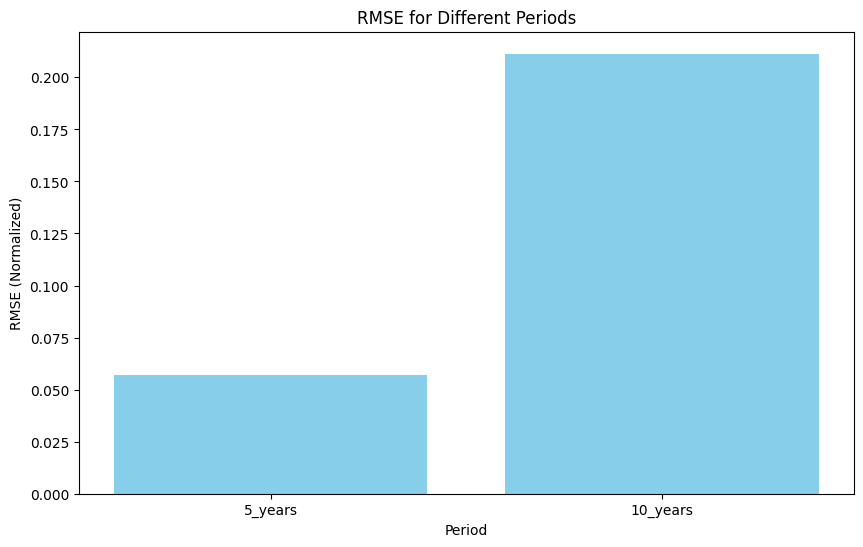

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

# Transformer 모델 생성 함수
def create_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.2):
    inputs = Input(shape=input_shape)

    x = inputs
    for _ in range(num_transformer_blocks):
        x = LayerNormalization(epsilon=1e-6)(x)
        x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout_rate)(x, x)
        x = Dropout(dropout_rate)(x)
        x = LayerNormalization(epsilon=1e-6)(x)
        x = Dense(ff_dim, activation="relu")(x)
        x = Dropout(dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)  # 종가를 예측하므로 출력 유닛 수는 1

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 모델 학습 및 평가 함수
def train_and_evaluate_model(train_X, train_y, val_X, val_y, test_X, test_y, scaler, period_name, head_size, num_heads, ff_dim, num_transformer_blocks, batch_size):
    input_shape = (train_X.shape[1], train_X.shape[2])  # 입력 데이터의 형태
    model = create_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.2)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # train_y, val_y, test_y를 1차원으로 변환 (단일 Close 값만 예측하기 때문)
    train_y = train_y[:, 0]
    val_y = val_y[:, 0]
    test_y = test_y[:, 0]

    history = model.fit(train_X, train_y, epochs=100, batch_size=batch_size, validation_data=(val_X, val_y),
                        callbacks=[early_stopping], verbose=1)

    # 모델 평가
    test_predictions = model.predict(test_X).flatten()
    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))

    # 예측된 값과 실제 값을 원래 스케일로 변환
    test_y_original = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()
    test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    return test_rmse, model, history, test_y_original, test_predictions_original

# 하이퍼파라미터 튜닝을 위한 설정
head_size_list = [64, 128]  # 헤드 사이즈를 64, 128로 설정
num_heads_list = [4, 8]  # 멀티 헤드 수를 4, 8로 설정
ff_dim_list = [128, 256]  # 피드포워드 레이어의 차원을 128, 256으로 설정
num_transformer_blocks_list = [2]  # Transformer 블록 수를 1, 2로 설정


# 튜닝 결과 저장용 리스트
tuning_results = []
prediction_results = []

# 각 기간별 데이터 학습 및 평가
periods = {
    '5_years': (five_year_train_X, five_year_train_y, five_year_val_X, five_year_val_y, five_year_test_X, five_year_test_y, scalers['Close']),
    '10_years': (ten_year_train_X, ten_year_train_y, ten_year_val_X, ten_year_val_y, ten_year_test_X, ten_year_test_y, scalers['Close'])
}

best_models = {}
histories = {}
best_results = {}
best_predictions = {}

for period_name, (train_X, train_y, val_X, val_y, test_X, test_y, scaler) in periods.items():
    best_rmse = float('inf')
    best_params = None
    best_test_predictions = None
    best_test_y = None
    for head_size, num_heads, ff_dim, num_transformer_blocks in itertools.product(head_size_list, num_heads_list, ff_dim_list, num_transformer_blocks_list):
        print(f"\nTraining and evaluating for period: {period_name} with head_size: {head_size}, num_heads: {num_heads}, ff_dim: {ff_dim}, num_transformer_blocks: {num_transformer_blocks}")
        test_rmse, model, history, test_y_values, test_predictions = train_and_evaluate_model(
            train_X, train_y, val_X, val_y, test_X, test_y, scaler, period_name, head_size, num_heads, ff_dim, num_transformer_blocks, batch_size=32
        )
        tuning_results.append([period_name, head_size, num_heads, ff_dim, num_transformer_blocks, test_rmse])

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = (head_size, num_heads, ff_dim, num_transformer_blocks)
            best_models[period_name] = model
            histories[period_name] = history
            best_results[period_name] = test_rmse
            best_test_predictions = test_predictions
            best_test_y = test_y_values

    # 예측값과 실제값 저장
    prediction_results.extend(
        list(zip([period_name] * len(best_test_y), range(len(best_test_y)), best_test_y, best_test_predictions))
    )
    best_predictions[period_name] = (best_test_y, best_test_predictions)

    print(f"Best RMSE for period {period_name}: {best_rmse} with params: {best_params}")

# 하이퍼파라미터 튜닝 결과를 CSV 파일로 저장
tuning_results_df = pd.DataFrame(tuning_results, columns=['Period', 'Head_Size', 'Num_Heads', 'FF_Dim', 'Num_Transformer_Blocks', 'Test_RMSE'])
tuning_results_df.to_csv('/content/AAPL_Transformer_D1_tuning.csv', index=False)

# 예측값과 실제값 결과를 CSV 파일로 저장
prediction_results_df = pd.DataFrame(prediction_results, columns=['Period', 'Index', 'Actual', 'Predicted'])
prediction_results_df.to_csv('/content/AAPL_Transformer_D1_prediction.csv', index=False)

# RMSE를 바 차트로 시각화
period_names = ['5_years', '10_years']
rmse_values = [best_results[period] for period in period_names]

plt.figure(figsize=(10, 6))
plt.bar(period_names, rmse_values, color='skyblue')
plt.xlabel('Period')
plt.ylabel('RMSE (Normalized)')
plt.title('RMSE for Different Periods')
plt.show()

# 변수에 저장 (다음 블럭에서 시각화에 사용하기 위해)
best_test_y_predictions = best_predictions


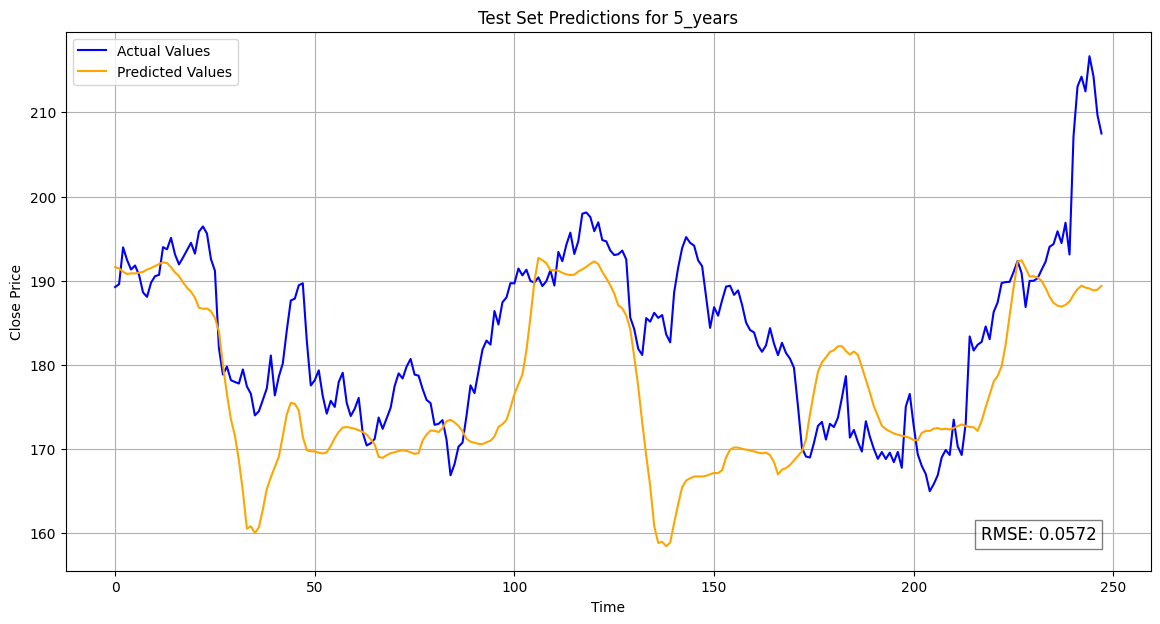

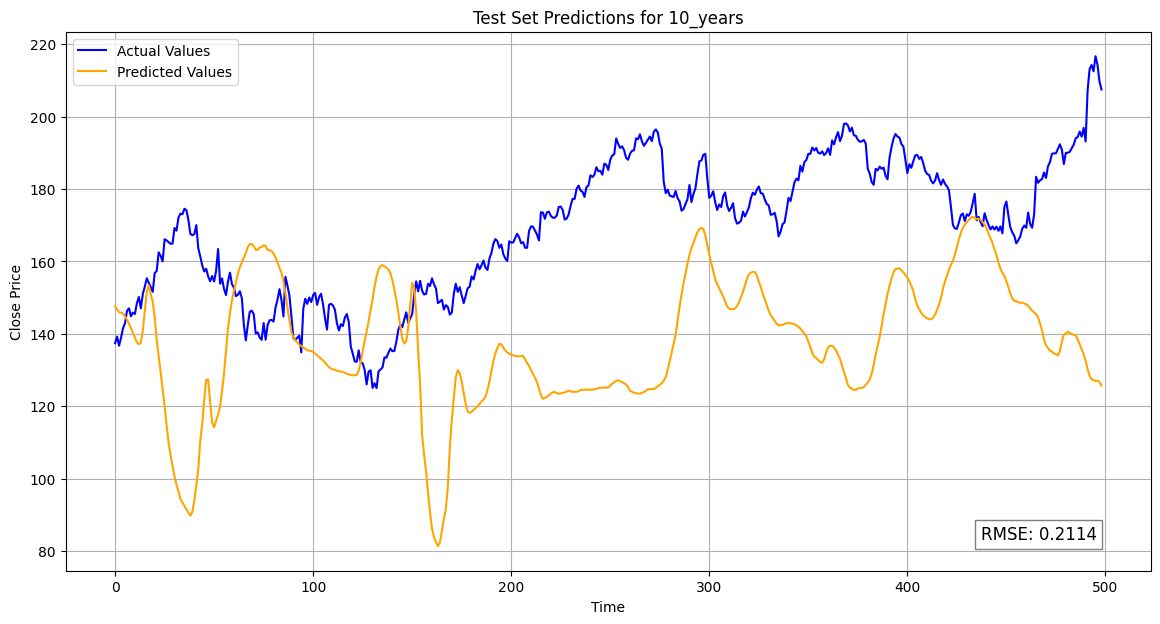

In [ ]:
import matplotlib.pyplot as plt

# Test 셋 결과 시각화 함수 정의
def plot_test_set_results(best_test_y_predictions, period_name, rmse_value):
    actual, predicted = best_test_y_predictions[period_name]

    plt.figure(figsize=(14, 7))
    plt.plot(actual, label='Actual Values', color='blue')
    plt.plot(predicted, label='Predicted Values', color='orange')
    plt.title(f'Test Set Predictions for {period_name}')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)

    # RMSE 값을 그래프에 표시
    plt.text(0.95, 0.05, f'RMSE: {rmse_value:.4f}',
             ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# 각 기간별로 결과 시각화
for period_name in best_test_y_predictions.keys():
    plot_test_set_results(best_test_y_predictions, period_name, best_results[period_name])
